In [1]:
import math
import numpy as np
import matplotlib.pyplot as ppt
%matplotlib inline

ANGLE_BINS = 16

DATA_ROOT = '/media/sf_Masterarbeit/data'
ORIG_SPECTRUM_PATH = DATA_ROOT + '/spectra/gtsrb-ae-0.05-minconfidence-0.5-maxorig-100-orig.npy'
AE_SPECTRUM_PATH = DATA_ROOT + '/spectra/gtsrb-ae-0.05-minconfidence-0.5-maxorig-100-ae.npy'
SAVE_PATH_PREFIX = '/media/sf_Masterarbeit/master-thesis/report/images/spectra/gtsrb-ae-0.05-minconfidence-0.5-maxorig-100'

(1, 1, 47, 47)
(1, 1, 47, 47)


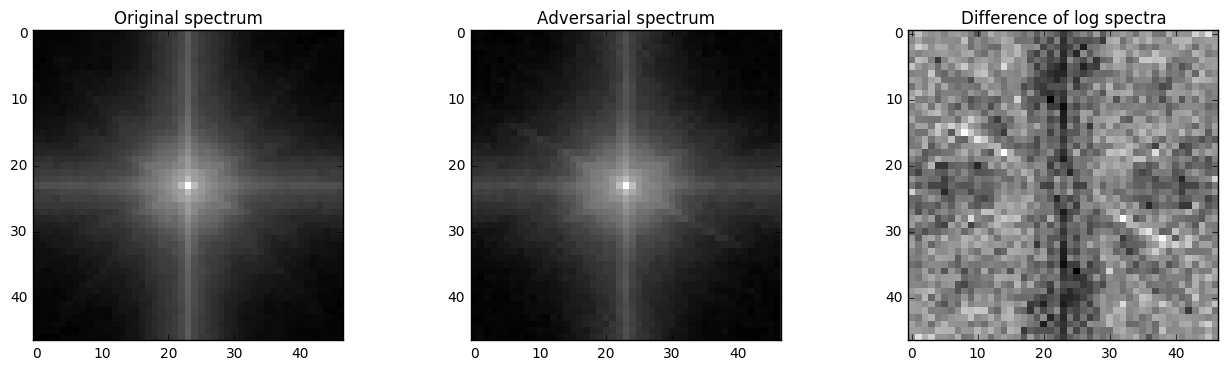

In [2]:
original_spectrum = np.load(ORIG_SPECTRUM_PATH)
ae_spectrum = np.load(AE_SPECTRUM_PATH)
print(original_spectrum.shape)
print(ae_spectrum.shape)
log_spectra_difference = np.log(ae_spectrum) - np.log(original_spectrum)

fig = ppt.figure(figsize=(16, 4))

ax = ppt.subplot(1, 3, 1)
ppt.imshow(np.log(original_spectrum[0, 0]), cmap='gray', interpolation='none')
ppt.title('Original spectrum')

ax = ppt.subplot(1, 3, 2)
ppt.imshow(np.log(ae_spectrum[0, 0]), cmap='gray', interpolation='none')
ppt.title('Adversarial spectrum')

ax = ppt.subplot(1, 3, 3)
ppt.imshow(log_spectra_difference[0, 0], cmap='gray', interpolation='none')
ppt.title('Difference of log spectra')

fig.savefig(SAVE_PATH_PREFIX + '-spectra.png', bbox_inches='tight')

In [3]:
def activity_distribution(spectrum, range_bins, angle_bins):
    spectrum = spectrum.reshape(spectrum.shape[-2:])
    if spectrum.shape[0] % 2 == 0: # If side length is even
        center = np.asarray(spectrum.shape) / 2 - np.asarray([1,1])
        spectrum = spectrum[1:,1:] # cut off asymmetric parts, shape is now uneven
    else: # Side length is odd
        center = np.asarray(spectrum.shape) / 2

    # Record the summed values at every distance and angle to the origin, and the number of summed values
    distance_distribution = np.zeros(shape=(2, range_bins))
    angle_distribution = np.zeros(shape=(2, angle_bins))
    
    # Maxima, the bins scale linearly between 0 and these values
    max_distance = math.ceil(np.linalg.norm(center))
    max_angle = 2 * math.pi
    
    for index, value in np.ndenumerate(spectrum):
        # Compute distance to origin and the corresponding bin index
        distance = np.linalg.norm(np.asarray(index) - center)
        distance_index = (distance / max_distance) * range_bins
        distance_index = int(math.floor(distance_index))
        distance_distribution[:, distance_index] += (value, 1) # Record data in appropriate bin
        
        # Compute angle and the corresponding bin index
        angle = math.atan2(center[0] - index[0], index[1] - center[1])
        if angle < 0: # atan2 gives values from -pi to pi. Shift them to 0 to 2pi
            angle += 2 * math.pi
        angle_index = (angle / max_angle) * angle_bins # from 0 to angle_bins
        angle_index = int(math.floor(angle_index))
        
        if not (np.asarray(index) == center).all(): #ignore origin since it has no well-defined angle
            angle_distribution[:, angle_index] += (value, 1) # Record data in appropriate bin
    
    # Normalize with the number of summed values. Use 0 if there was no point at that distance.
    distance_distribution = np.where(distance_distribution[1] == 0, 0, distance_distribution[0] / distance_distribution[1])
    angle_distribution = angle_distribution[0] / (angle_distribution[1])
    
    return distance_distribution, angle_distribution

distance_bins = int(round(np.linalg.norm(original_spectrum.shape) / 2))
print('Using {0} distance bins and {1} angle bins'.format(distance_bins, ANGLE_BINS))

original_distance_distribution, original_angle_distribution = activity_distribution(original_spectrum, distance_bins, ANGLE_BINS)
ae_distance_distribution, ae_angle_distribution = activity_distribution(ae_spectrum, distance_bins, ANGLE_BINS)
diff_distance_distribution, diff_angle_distribution = activity_distribution(log_spectra_difference, distance_bins, ANGLE_BINS)

Using 33 distance bins and 16 angle bins


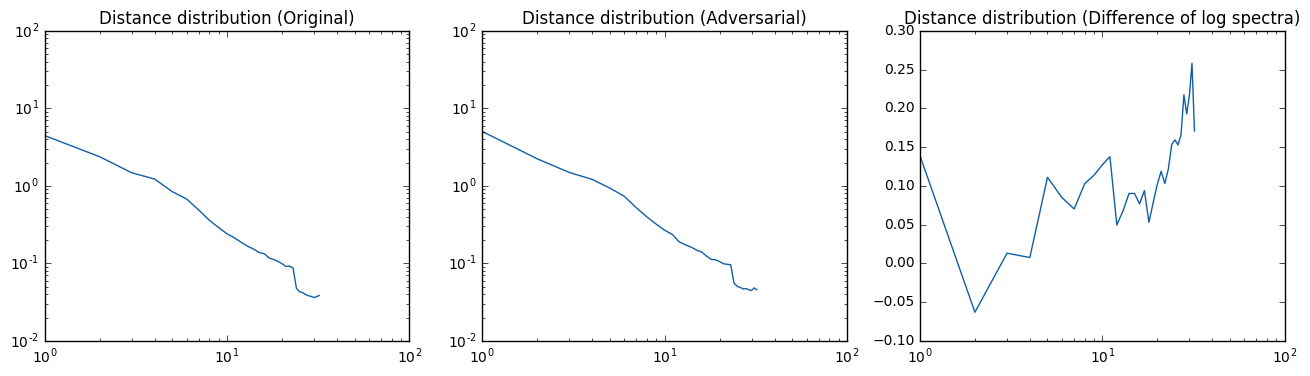

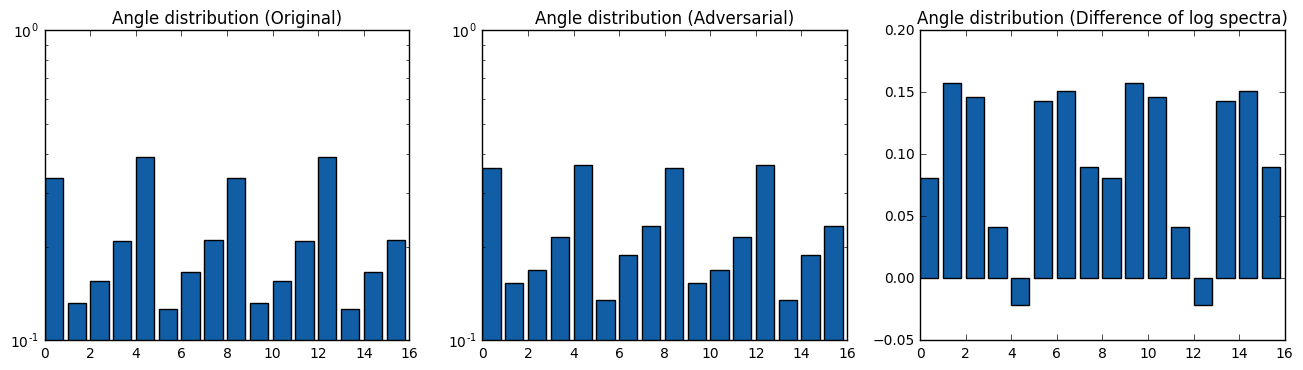

In [4]:
fig = ppt.figure(figsize=(16, 4))

ax = ppt.subplot(1, 3, 1)
ax.set_xscale('log')
ax.set_yscale('log')
ppt.plot(original_distance_distribution, color='#115EA6')
ppt.title('Distance distribution (Original)')

ax = ppt.subplot(1, 3, 2)
ax.set_xscale('log')
ax.set_yscale('log')
ppt.plot(ae_distance_distribution, color='#115EA6')
ppt.title('Distance distribution (Adversarial)')

ax = ppt.subplot(1, 3, 3)
ax.set_xscale('log')
#ax.set_yscale('log')
ppt.plot(diff_distance_distribution, color='#115EA6')
ppt.title('Distance distribution (Difference of log spectra)')

fig.savefig(SAVE_PATH_PREFIX + '-distance-{0}-bins.png'.format(distance_bins), bbox_inches='tight')



fig = ppt.figure(figsize=(16, 4))

ax = ppt.subplot(1, 3, 1)
#ax.set_xscale('log')
ax.set_yscale('log')
ppt.bar(np.arange(ANGLE_BINS), original_angle_distribution, color='#115EA6')
ppt.title('Angle distribution (Original)')

ax = ppt.subplot(1, 3, 2)
#ax.set_xscale('log')
ax.set_yscale('log')
ppt.bar(np.arange(ANGLE_BINS), ae_angle_distribution, color='#115EA6')
ppt.title('Angle distribution (Adversarial)')

ax = ppt.subplot(1, 3, 3)
#ax.set_xscale('log')
#ax.set_yscale('log')
ppt.bar(np.arange(ANGLE_BINS), diff_angle_distribution, color='#115EA6')
ppt.title('Angle distribution (Difference of log spectra)')

fig.savefig(SAVE_PATH_PREFIX + '-angle-{0}-bins.png'.format(ANGLE_BINS), bbox_inches='tight')